Part a) Ordinary Least Square (OLS) for the Runge function

In [1]:
#Starting by generating point of x in the interval [-1,1]

import numpy as np 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#choosing datapoints between 1 and -1 
n = 100
x = np.linspace (-1,1, n)


#From the Runge function: for every x, compute the correspponding y
y = 1/(1 + 25 * x**2)
#Adding noise (Gaussian) with mean 0 and variance 1: N(0,1)
noise = np.random.normal(0,1,n)
y_noisy = y + 0.1 * noise


#Creating feature matrix with shape [1,x,x^2,x^3,x^4 ...]
def polynomial_features(x, p, intercept = True):
    n = len(x)
    if intercept == True: # adding functionality for intercept
        X = np.zeros((n, p + 1))
        X[:, 0] = 1  # intercept column first
        for i in range(1, p + 1): # from 1 to p inclusive
            X[:, i] = x ** i
    else: #if intercept is False
            X = np.zeros((n, p)) #no intercept column
            for i in range(p): #from 0 to p-1
                X[:, i] = x ** (i + 1) 

    return X

def OLS_parameters(X, y):
    X_T_X = np.linalg.pinv(X.T @ X)
    beta_OLS = X_T_X @ X.T @ y
    return beta_OLS

def R2_score(actual , predicted):
     numerator = np.sum((actual - predicted) ** 2) #the numerator of the r2 formula
     actual_mean = np.mean(actual) #our mean value of the actual values
     denominator = np.sum((actual - actual_mean) ** 2) #denominator of the r2 formula
     R2 = 1 - (numerator / denominator) #calculating the r2
     return R2




In [2]:
#we start by creating the design matrix and splitting it into training and test data
X = polynomial_features(x, 15)
X_train , X_test , y_train , y_test = train_test_split(X , y_noisy , test_size = 0.2)


#thereby calculating the OLS coefficients
beta = OLS_parameters(X_train, y_train)
y_pred = X_test @ beta #here we predict the y values using the coefficient calculated

mse_y_pred = mean_squared_error(y_test , y_pred) # calculating the MSE
R2 = R2_score(y_test , y_pred) #calculating the R2 score



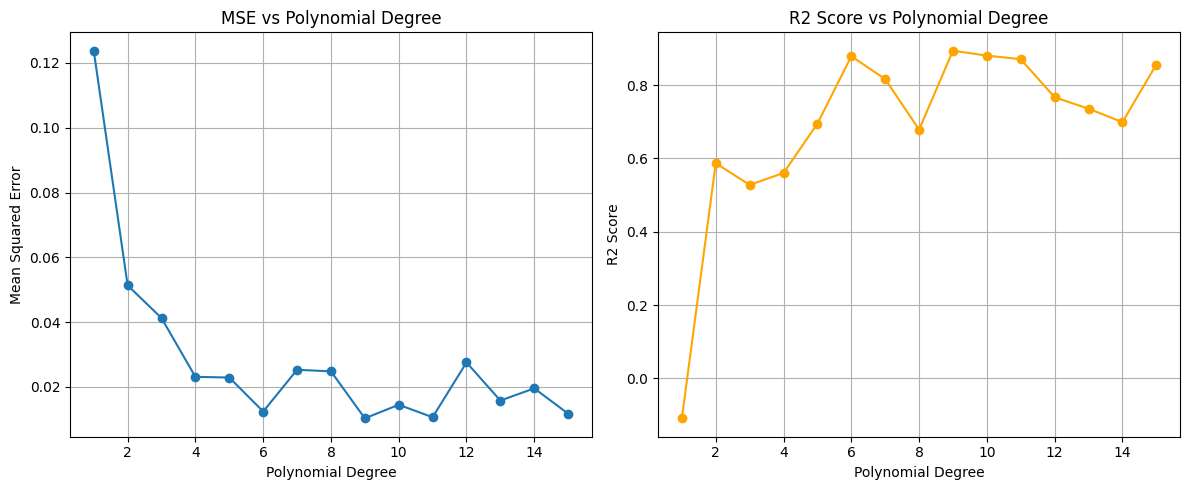

In [3]:
import matplotlib.pyplot as plt

mse_values_OLS = np.zeros(15) #storing the mse values for each polynomial degree
R2_values_OLS = np.zeros(15) #storing the r2 values for each polynomial

for i in range(1 , 16):
    X = polynomial_features(x , i)
    X_train , X_test , y_train , y_test = train_test_split(X , y_noisy , test_size = 0.2)
    beta = OLS_parameters(X_train , y_train)
    y_pred = X_test @ beta
    mse_values_OLS[i-1] = mean_squared_error(y_test , y_pred)
    R2_values_OLS[i-1] = R2_score(y_test , y_pred)


#now we create degrees array as well
degrees = np.arange(1 , 16)
plt.figure(figsize = (12 , 5))
plt.subplot(1 , 2 , 1)
plt.plot(degrees , mse_values_OLS , marker = 'o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Polynomial Degree')
plt.grid()
plt.subplot(1 , 2 , 2)
plt.plot(degrees , R2_values_OLS , marker = 'o' , color = 'orange')
plt.xlabel('Polynomial Degree')
plt.ylabel('R2 Score')
plt.title('R2 Score vs Polynomial Degree')
plt.grid()
plt.tight_layout()
plt.show()

### b)

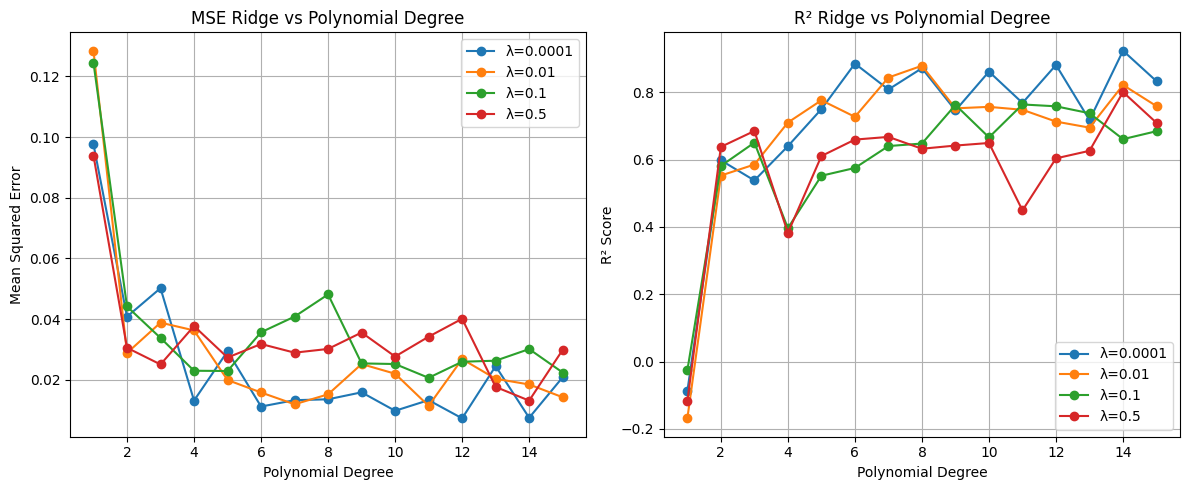

In [4]:
def ridge_regression(X , y , lamb):
    I = np.identity(X.shape[1]) # need to have the identity matrix
    return (np.linalg.inv(X.T @ X + lamb * I) @ X.T @ y) #the actual expression for optimal beta

#setting differing values for lambda
lambd = [0.0001 , 0.01 , 0.1 , 0.5]

mse_values_ridge = np.zeros((15 , len(lambd))) #defining the mse values matrix
R2_values_ridge = np.zeros((15, len(lambd))) #R2 matrix for storage

for l in range(len(lambd)): #we want to test for all lambdas
    for i in range(1 , 16): #we want to test for teh different polynomials
        X = polynomial_features(x , i)
        X_train , X_test , y_train , y_test = train_test_split(X , y_noisy , test_size = 0.2) #split the data
        beta_ridge = ridge_regression(X_train , y_train , lambd[l]) #do the ridge regression
        y_pred_ridge = X_test @ beta_ridge #do the prediction

        mse_values_ridge[i-1, l ] = mean_squared_error(y_test , y_pred_ridge) #calculate the mse values
        R2_values_ridge[i-1 , l] = R2_score(y_test , y_pred_ridge) #calculate the r2 values




plt.figure(figsize=(12, 5))

# ---- MSE plot ----
plt.subplot(1, 2, 1)
for l in range(len(lambd)):
    plt.plot(degrees, mse_values_ridge[:, l], marker='o', label=f"λ={lambd[l]}")
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('MSE Ridge vs Polynomial Degree')
plt.legend()
plt.grid()

# ---- R² plot ----
plt.subplot(1, 2, 2)
for l in range(len(lambd)):
    plt.plot(degrees, R2_values_ridge[:, l], marker='o', label=f"λ={lambd[l]}")
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.title('R² Ridge vs Polynomial Degree')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

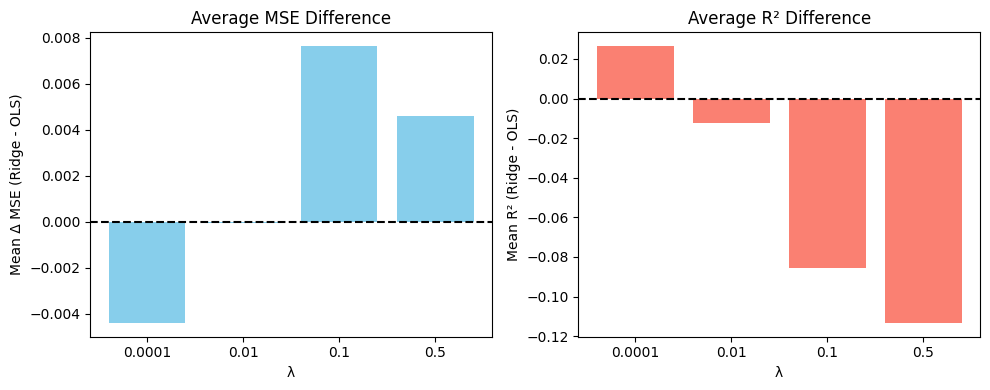

In [5]:
difference_mse = np.zeros((15 , 4))
difference_r2 = np.zeros((15 , 4))
for j in range(len(lambd)):
    for i in range(1 , 16):
        difference_mse[i-1, j] = mse_values_ridge[i-1, j] - mse_values_OLS[i-1]
        difference_r2[i-1 , j] = R2_values_ridge[i-1 , j] - R2_values_OLS[i-1]


mean_diff_mse = np.mean(difference_mse, axis=0)   # one value per λ
mean_diff_r2  = np.mean(difference_r2, axis=0)    # one value per λ

plt.figure(figsize=(10,4))

# ---- Mean difference in MSE ----
plt.subplot(1,2,1)
plt.bar([str(l) for l in lambd], mean_diff_mse, color='skyblue')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("λ")
plt.ylabel("Mean Δ MSE (Ridge - OLS)")
plt.title("Average MSE Difference")

# ---- Mean difference in R² ----
plt.subplot(1,2,2)
plt.bar([str(l) for l in lambd], mean_diff_r2, color='salmon')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("λ")
plt.ylabel("Mean R² (Ridge - OLS)")
plt.title("Average R² Difference")

plt.tight_layout()
plt.show()


Part c) Implement code for Gradient descent

In [6]:
eta = 0.001
num_iters = 1000   # try larger
n_samples, n_features = X.shape
lam = 0.1

theta_gdOLS = np.zeros(n_features)
theta_gdRidge = np.zeros(n_features)

def ols_gradient(X, y, theta):
    return (2/n_samples) * X.T @ (X @ theta - y)

def ridge_gradient(X, y, theta, lam):
    return (2/n_samples) * X.T @ (X @ theta - y) + 2 * lam  * theta

for t in range(num_iters):
    grad_OLS = ols_gradient(X, y, theta_gdOLS)
    grad_Ridge = ridge_gradient(X, y, theta_gdRidge, lam)

    theta_gdOLS -= eta * grad_OLS
    theta_gdRidge -= eta * grad_Ridge

print("Gradient Descent OLS coefficients:", theta_gdOLS)
print("Gradient Descent Ridge coefficients:", theta_gdRidge)

def Ridge_parameters(X, y, lam):
    I = np.eye(X.shape[1])  # Identity matrix
    beta_ridge = np.linalg.inv(X.T @ X + lam * I) @ (X.T @ y)
    return beta_ridge

def OLS_parameters(X, y):
    beta_OLS = np.linalg.inv(X.T @ X) @ X.T @ y
    return beta_OLS

theta_closed_formOLS = OLS_parameters(X, y)
theta_closed_formRidge = Ridge_parameters(X, y, lam)

print("Closed-form OLS:", theta_closed_formOLS)
print("Closed-form Ridge:", theta_closed_formRidge)

Gradient Descent OLS coefficients: [ 2.47495041e-01 -7.75088891e-18 -3.61364051e-02 -5.95495523e-18
 -3.04109222e-02 -6.36824431e-18 -2.33919492e-02 -6.08824974e-18
 -1.87469622e-02 -6.03975138e-18 -1.56118003e-02 -6.03559706e-18
 -1.33909562e-02 -6.05506051e-18 -1.17490701e-02 -5.42736880e-18]
Gradient Descent Ridge coefficients: [ 2.30420890e-01 -7.19211753e-18 -3.10402586e-02 -5.36066398e-18
 -2.66411144e-02 -5.64906305e-18 -2.05913142e-02 -5.30807805e-18
 -1.65430623e-02 -5.33855599e-18 -1.37985243e-02 -5.28436256e-18
 -1.18494434e-02 -5.34633799e-18 -1.04059963e-02 -4.79258676e-18]
Closed-form OLS: [ 9.53707259e-01 -5.13901097e-08 -1.46925186e+01  1.88277352e-06
  1.16264030e+02 -2.01419944e-05 -4.83031103e+02  9.55294415e-05
  1.10310225e+03 -2.33339247e-04 -1.39261912e+03  3.05820876e-04
  9.10192470e+02 -2.04346503e-04 -2.40144277e+02  5.46486989e-05]
Closed-form Ridge: [ 6.26981867e-01 -3.44565670e-15 -1.90011108e+00  2.42222695e-14
  1.00350121e+00 -3.62419091e-14  7.08782716